## Resume_Screening_with_NLP_prototype

The various tasks at hand are as follows:

*  Exploratory Data Analysis
*  Data pre-processing
*  Data Modeling
*  Learining the top keywords across resumes

This project demonstrates an AI-based resume screening system using Natural Language Processing (NLP). It automates the evaluation of resumes by extracting relevant information and comparing it to job descriptions. The prototype uses techniques like text preprocessing, TF-IDF vectorization, and cosine similarity to rank resumes based on their relevance to the job requirements, helping streamline the recruitment process.

In [4]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [5]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
df = pd.read_csv(r'C:\Users\hp\Downloads\archive (4)\UpdatedResumeDataSet.csv')

In [7]:
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [9]:
df.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [10]:
print(df.isnull())

     Category  Resume
0       False   False
1       False   False
2       False   False
3       False   False
4       False   False
..        ...     ...
957     False   False
958     False   False
959     False   False
960     False   False
961     False   False

[962 rows x 2 columns]


# 1. Exploratory Data Analysis (EDA)

In [12]:
category = df['Category'].value_counts().reset_index()
category

,Category,count
0,Java Developer,84
1,Testing,70
2,DevOps Engineer,55
3,Python Developer,48
4,Web Designing,45
5,HR,44
6,Hadoop,42
7,Blockchain,40
8,ETL Developer,40
9,Operations Manager,40


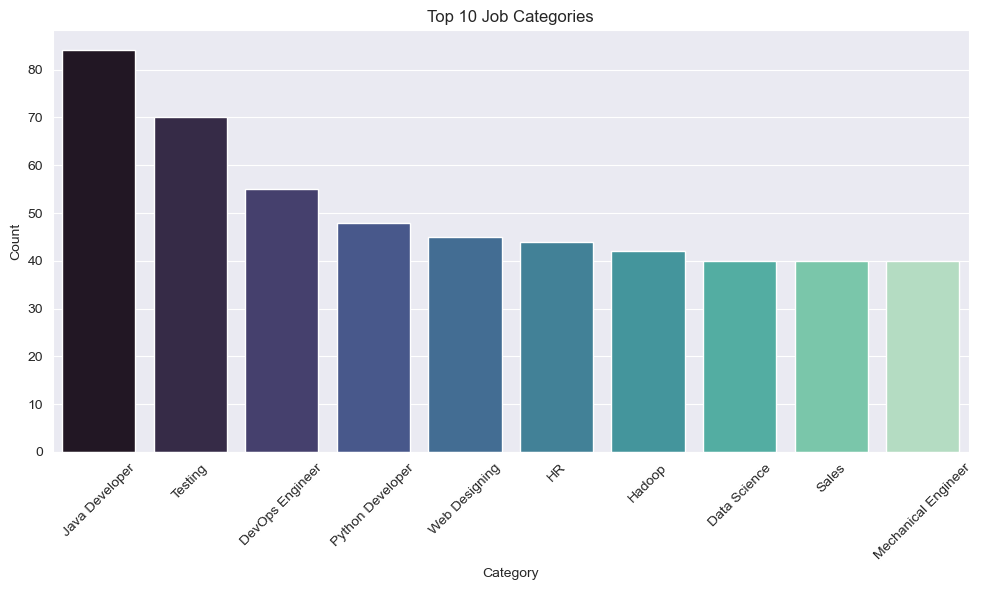

In [13]:

# Sort the DataFrame by 'count' and take the top 10
top_categories = category.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='count', data=top_categories, palette='mako')
plt.title('Top 10 Job Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


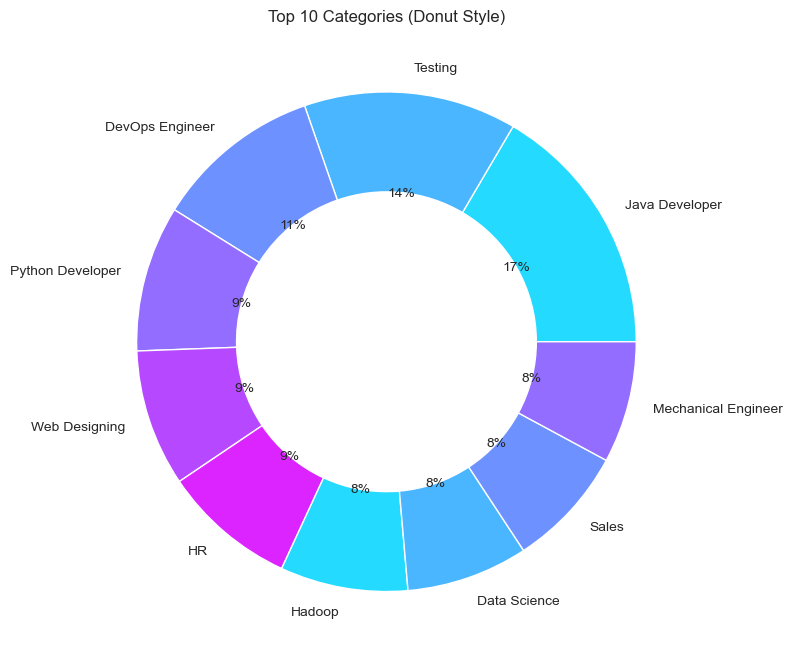

In [14]:
# Make sure you're using the correct column names
top_categories = category.sort_values(by='count', ascending=False).head(10)

plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    top_categories['count'], 
    labels=top_categories['Category'],
    colors=sns.color_palette('cool'), 
    autopct='%.0f%%',
    wedgeprops=dict(width=0.4)  # Donut style
)

plt.title('Top 10 Categories (Donut Style)')
plt.tight_layout()
plt.show()


# 2. Data Pre-processing:
1. Data Cleaning
2. Data Encoding

In [16]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    return resumeText

In [17]:
df['cleaned'] = df['Resume'].apply(lambda x:cleanResume(x))
df.head()

,Category,Resume,cleaned
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...


## TF-IDF model

In [19]:
# Create the TF-IDF model
tfidf = TfidfVectorizer(max_features=1500)  # You can tune max_features

# Transform the resume text
X = tfidf.fit_transform(df["cleaned"]).toarray()


In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df["Category"])


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
corpus = ""
for i in range(len(df)):
    corpus += df["cleaned"][i]


## Use of NLTK

In [24]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Tokenization , Lemmatization and Stemming

In [28]:
import re

# Initialize tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

def cleanResume(resumeText):
    # Basic text cleaning
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)        # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)          # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)        # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuation
    resumeText = re.sub(r'[^\x00-\x7f]', r' ', resumeText)  # remove non-ASCII characters
    resumeText = re.sub('\s+', ' ', resumeText)          # remove extra whitespace

    # Tokenization
    tokens = tokenizer.tokenize(resumeText.lower())      # tokenize and convert to lowercase

    # Apply lemmatization and stemming
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]

    # Rejoin into a single string
    return ' '.join(tokens)


In [29]:
# Now encode the data
label = LabelEncoder()
df['new_Category'] = label.fit_transform(df['Category'])
df.head()

,Category,Resume,cleaned,new_Category
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills Programming Languages Python pandas num...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details May 2013 to May 2017 B E UIT...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",Areas of Interest Deep Learning Control System...,6
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Tableau SAP HANA SQL ...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",Education Details MCA YMCAUST Faridabad Haryan...,6


(array([ 82.,  68.,  97.,  83.,  70., 116., 124.,  95.,  72., 155.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

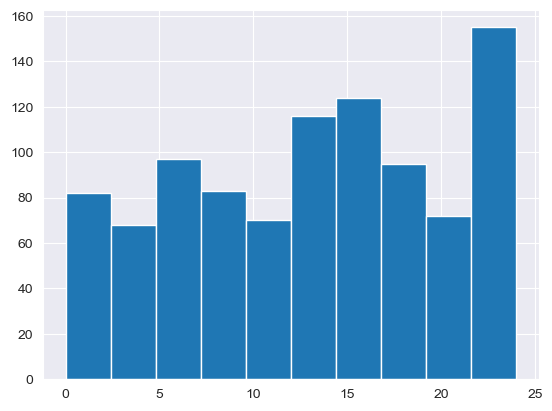

In [30]:
plt.hist(df['new_Category'])

### Vectorization

In [32]:
# Vectorizing the cleaned columns
text = df['cleaned'].values
target = df['new_Category'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=1500)
word_vectorizer.fit(text)
WordFeatures = word_vectorizer.transform(text)

In [33]:
WordFeatures.shape

(962, 1500)

# 3: Train Test Data and Modeling

In [35]:
# Separate train and test data
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, target, random_state=24, test_size=0.2)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((769, 1500), (193, 1500), (769,), (193,))

In [37]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=15, weights='uniform'))
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=15))

In [38]:
# Prediction
y_pred = model.predict(X_test)

In [39]:
print(f'---------------------------------\n| Training Accuracy   :- {round(model.score(X_train, y_train)*100, 2)}% |')
print(f'---------------------------------\n| Validation Accuracy :- {round(model.score(X_test, y_test)*100, 2)}% |\n---------------------------------')

---------------------------------
| Training Accuracy   :- 94.8% |
---------------------------------
| Validation Accuracy :- 93.26% |
---------------------------------


In [40]:

# Initialize tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

def cleanResume(resumeText):
    # Basic text cleaning
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)        # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)          # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)        # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuation
    resumeText = re.sub(r'[^\x00-\x7f]', r' ', resumeText)  # remove non-ASCII characters
    resumeText = re.sub('\s+', ' ', resumeText)          # remove extra whitespace

    # Tokenization
    tokens = tokenizer.tokenize(resumeText.lower())      # tokenize and convert to lowercase

    # Apply lemmatization and stemming
    tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]

    # Rejoin into a single string
    return ' '.join(tokens)


### Multinomial Naive Bayes


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       1.00      1.00      1.00         9
           2       1.00      0.67      0.80         6
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         7
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        10
           9       1.00      0.67      0.80         6
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         6
          13       1.00      1.00      1.00         6
          14       1.00      1.00      1.00         8
          15       0.89      1.00      0.94        16
          16       1.00      1.00      1.00         7
  

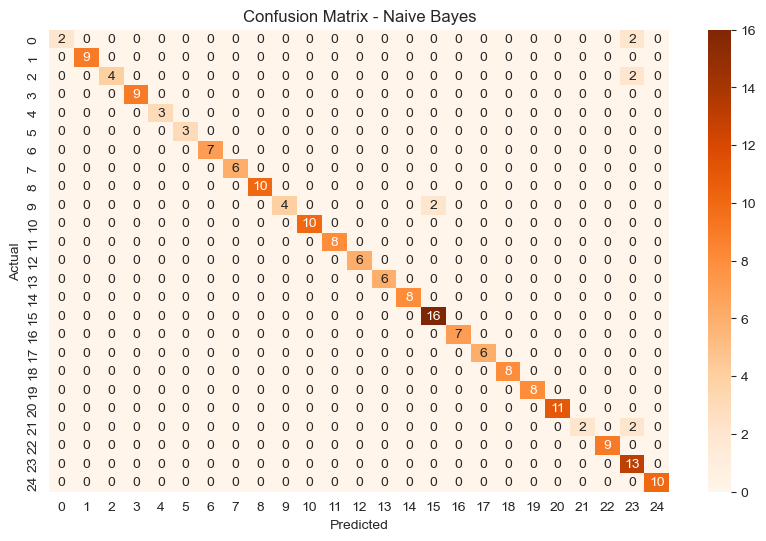

In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize and train the model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred = nb_model.predict(X_test)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# 4. To learn the top keywords to analyze.

In [44]:
import nltk
nltk.download('punkt')  # Correct package

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk

# Make sure required resources are downloaded
nltk.download('stopwords')

# Function to clean and tokenize text
def preprocess_text(text):
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text.lower())
    return ' '.join([word for word in words if word not in stopwords.words('english')])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:

from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

# Sample text
sample_text = "This is a sample resume text after preprocessing and cleaning."

# Tokenize
tokenizer = RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(sample_text.lower())

# Remove stopwords
filtered_words = [word for word in tokens if word not in stopwords.words('english')]

# Lemmatize
lemmatizer = WordNetLemmatizer()
lem_words = [lemmatizer.lemmatize(word) for word in filtered_words]

# Now you can use it for wordcloud
res = ' '.join([i for i in lem_words if not i.isdigit()])
print(res)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


sample resume text preprocessing cleaning


In [47]:
print(df)

         Category                                             Resume  \
0    Data Science  Skills * Programming Languages: Python (pandas...   
1    Data Science  Education Details \r\nMay 2013 to May 2017 B.E...   
2    Data Science  Areas of Interest Deep Learning, Control Syste...   
3    Data Science  Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...   
4    Data Science  Education Details \r\n MCA   YMCAUST,  Faridab...   
..            ...                                                ...   
957       Testing  Computer Skills: â¢ Proficient in MS office (...   
958       Testing  â Willingness to accept the challenges. â ...   
959       Testing  PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...   
960       Testing  COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...   
961       Testing  Skill Set OS Windows XP/7/8/8.1/10 Database MY...   

                                               cleaned  new_Category  
0    Skills Programming Languages Python pandas num...          

### Word cloud for each categories
Separate word cloud for each Category like:
* Data Science
* HR
* DevOps
* Testing

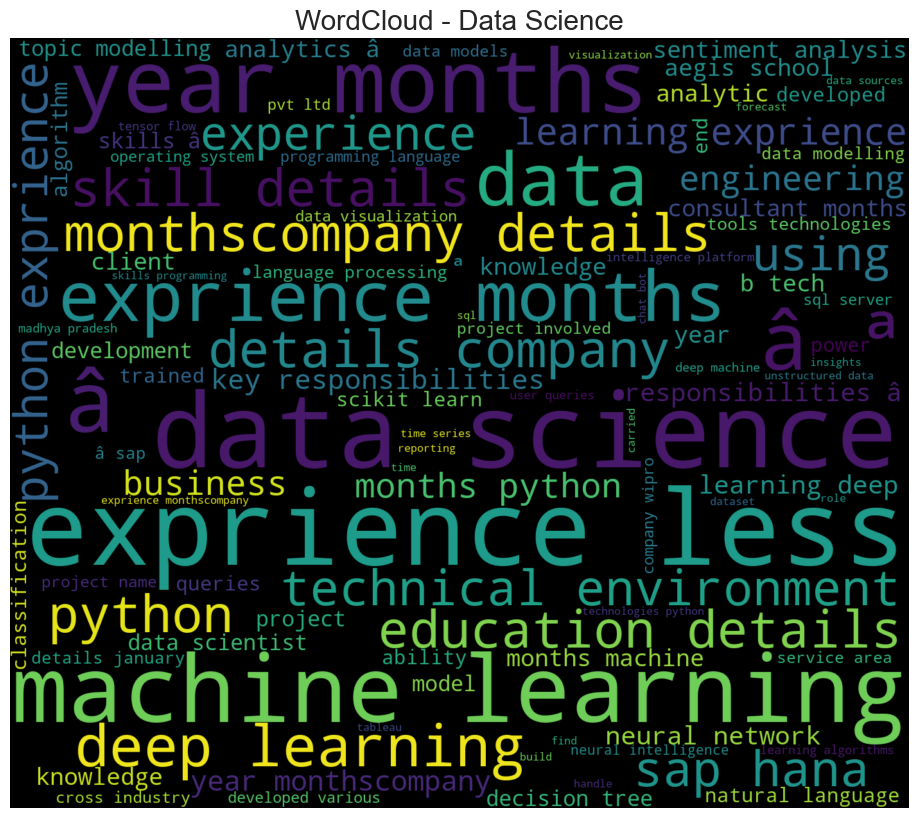

In [49]:
# WordCloud for Data Science
data_sci = df[df['Category'] == 'Data Science']
text_ds = ' '.join(data_sci['Resume'].astype(str)).lower()

plt.subplots(figsize=(16, 10))
wordcloud = WordCloud(background_color='black', max_words=100, width=1400, height=1200).generate(text_ds)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud - Data Science', fontsize=20)
plt.axis('off')
plt.show()


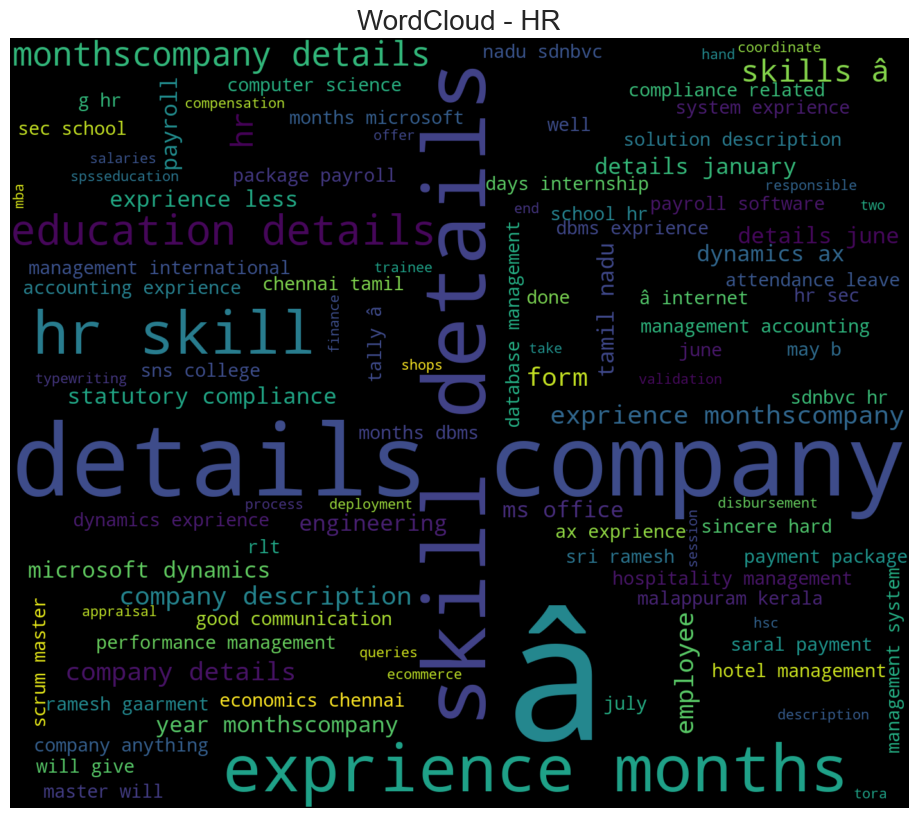

In [50]:
# WordCloud for HR
hr = df[df['Category'] == 'HR']
text_hr = ' '.join(hr['Resume'].astype(str)).lower()

plt.subplots(figsize=(16, 10))
wordcloud = WordCloud(background_color='black', max_words=100, width=1400, height=1200).generate(text_hr)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud - HR', fontsize=20)
plt.axis('off')
plt.show()

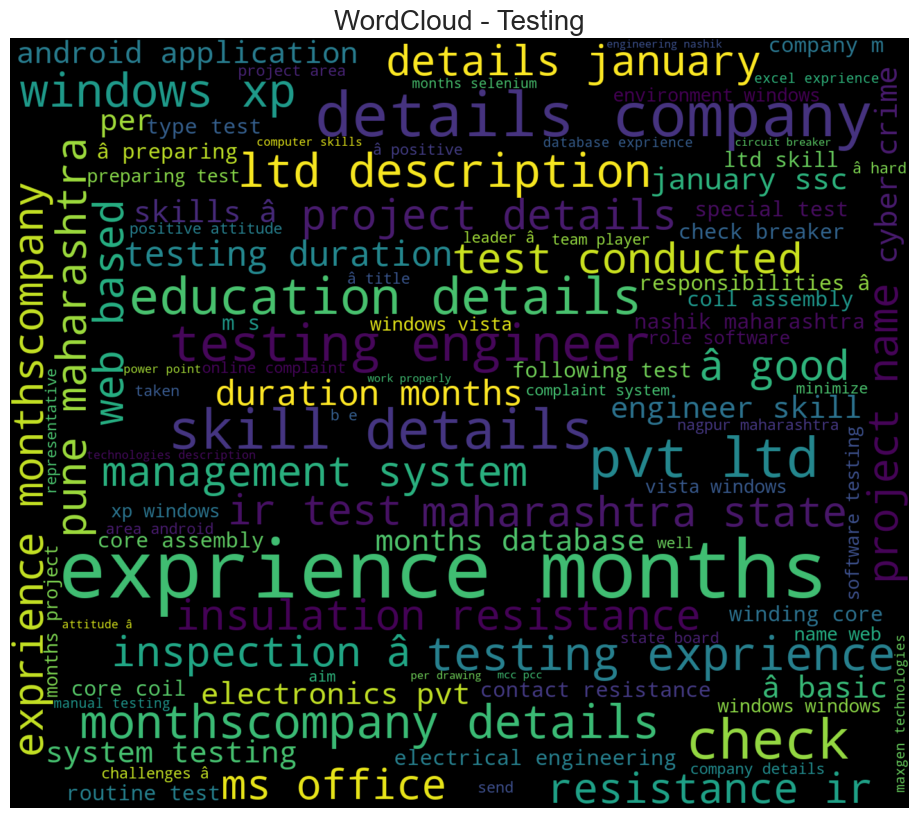

In [51]:
# WordCloud for Testing
testing = df[df['Category'] == 'Testing']
text_test = ' '.join(testing['Resume'].astype(str)).lower()

plt.subplots(figsize=(16, 10))
wordcloud = WordCloud(background_color='black', max_words=100, width=1400, height=1200).generate(text_test)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud - Testing', fontsize=20)
plt.axis('off')
plt.show()

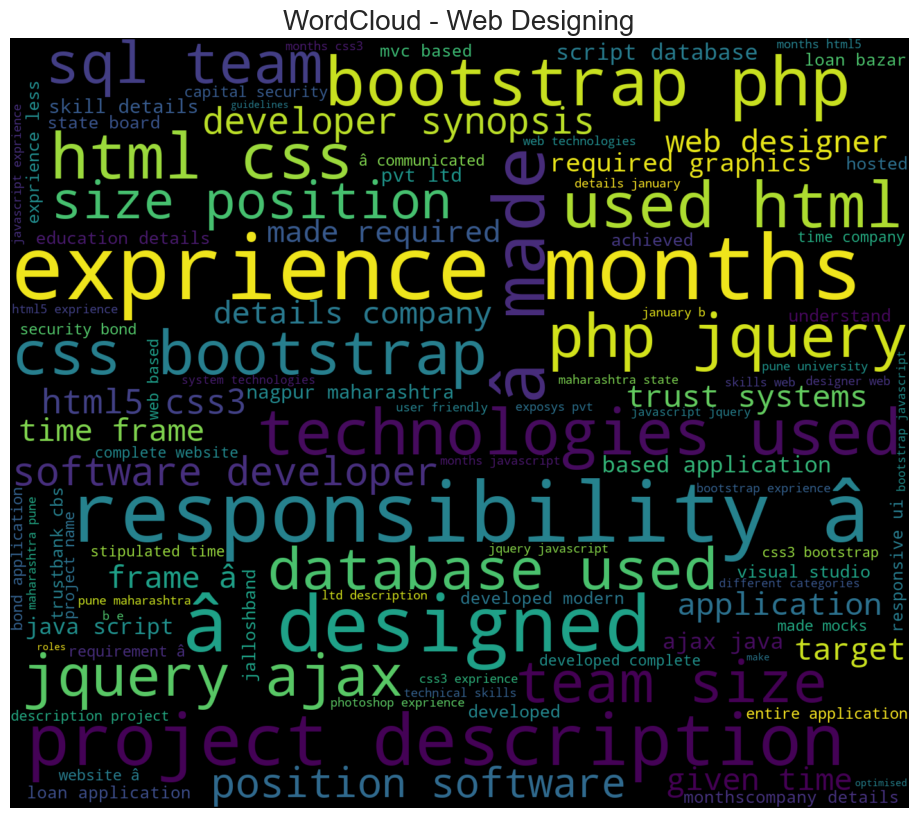

In [52]:
# WordCloud for Web Designing
web_design = df[df['Category'] == 'Web Designing']
text_web = ' '.join(web_design['Resume'].astype(str)).lower()

plt.subplots(figsize=(16, 10))
wordcloud = WordCloud(background_color='black', max_words=100, width=1400, height=1200).generate(text_web)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud - Web Designing', fontsize=20)
plt.axis('off')
plt.show()
